### Урок 5

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Импорт необходимых библиотек

In [1]:
import pandas as pd  # Импортируем библиотеку pandas и сокращаем её до pd
import numpy as np   # Импортируем библиотеку numpy и сокращаем её до np
import seaborn as sns  # Импорт библиотеки Seaborn для визуализации данных
# Импортируем функции для работы с пайплайнами
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion  
# Импортируем базовые классы для создания собственных трансформаторов
from sklearn.base import BaseEstimator, TransformerMixin    
# Импортируем функции для разделения данных и кросс-валидации
from sklearn.model_selection import train_test_split, cross_val_score  
import itertools  # Импортируем библиотеку itertools для работы с итераторами


# Импортируем необходимые метрики из библиотеки sklearn.metrics
from sklearn.metrics import (
    f1_score,            # F1-мера
    roc_auc_score,       # Площадь под ROC-кривой
    roc_curve,           # ROC-кривая
    precision_score,     # Точность
    classification_report,  # Отчёт о классификации
    precision_recall_curve,  # Кривая точность-полнота
    confusion_matrix       # Матрица ошибок
)

# Импортируем класс LogisticRegression для логистической регрессии
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier  # Импорт класса CatBoostClassifier из библиотеки CatBoost
from sklearn.ensemble import RandomForestClassifier  # Импорт класса RandomForestClassifier из scikit-learn
from sklearn.ensemble import GradientBoostingClassifier  # Импорт класса GradientBoostingClassifier из scikit-learn

from sklearn.preprocessing import StandardScaler  # Импорт класса StandardScaler из scikit-learn
# Импортируем класс GridSearchCV для поиска оптимальных параметров модели
from sklearn.model_selection import GridSearchCV 

import matplotlib.pyplot as plt  # Импортируем библиотеку matplotlib.pyplot для построения графиков

# Магическая команда Jupyter Notebook для отображения графиков в ячейке кода
%matplotlib inline  

### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)



In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O ./data/churn_data.csv

--2023-11-09 22:10:05--  https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91
Resolving drive.google.com (drive.google.com)... 142.250.74.142
Connecting to drive.google.com (drive.google.com)|142.250.74.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rh70bo2ml92fcpcodn7v32r14tvpm2rc/1699557000000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download&uuid=7fd43784-6844-4d6c-af5b-5bebf42a64c3 [following]
--2023-11-09 22:10:06--  https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rh70bo2ml92fcpcodn7v32r14tvpm2rc/1699557000000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download&uuid=7fd43784-6844-4d6c-af5b-5bebf42a64c3
Resolving doc-14-c0-docs.googleusercontent.com (doc-14-c0-docs.googleusercontent.com)... 142.250.74.129
Connecting to doc-14-c0-docs.googleusercont

In [3]:
# Считываем данные из файла 'churn_data.csv' и сохраняем в переменную df
df = pd.read_csv('./data/churn_data.csv')

# Выводим первые пять строк данных
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [5]:
# Класс FeatureSelector предназначен для выбора указанного столбца из DataFrame
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

# Класс NumberSelector предназначен для выбора одного числового столбца из DataFrame
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

# Класс OHEEncoder предназначен для выполнения one-hot encoding на указанном столбце DataFrame
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


In [6]:
# Создаем копию DataFrame df под именем df_main
df_main = df.copy()

# Выбираем числовые (включая float и int) столбцы из df_main, исключая неинформативные столбцы
df_main_columns = df_main.drop(columns=['RowNumber', 'CustomerId', 'Surname', \
                                        'Exited']).select_dtypes(include=['float', int])

# Определяем столбцы, содержащие только два уникальных значения
base_columns = [col for col in df_main_columns.columns if df_main_columns[col].nunique() == 2]

# Определяем столбцы, содержащие более двух уникальных значений
continuous_columns = [col for col in df_main_columns.columns if df_main_columns[col].nunique() > 2]

# Определяем категориальные столбцы
categorical_columns = df_main.drop(columns=['RowNumber', 'CustomerId', 'Surname', \
                                            'Exited']).select_dtypes(exclude=['float', int]).columns.to_list()

# Выводим результаты
print("Continuous columns:", continuous_columns)
print("Base columns:", base_columns)
print("Categorical columns:", categorical_columns)

Continuous columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Base columns: ['HasCrCard', 'IsActiveMember']
Categorical columns: ['Geography', 'Gender']


In [7]:
# Создаем пустой список final_transformers для хранения трансформаторов
final_transformers = []

# Для каждого категориального столбца создаем трансформатор, который включает в себя FeatureSelector и OHEEncoder
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),  # Выбор указанного столбца
        ('ohe', OHEEncoder(key=cat_col))  # Применение one-hot encoding
    ])
    final_transformers.append((cat_col, cat_transformer))

# Для каждого непрерывного столбца создаем трансформатор, который включает в себя NumberSelector и StandardScaler
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),  # Выбор указанного числового столбца
        ('standard', StandardScaler())  # Стандартизация значений
    ])
    final_transformers.append((cont_col, cont_transformer))

# Для каждого бинарного столбца создаем трансформатор, который включает в себя NumberSelector
for base_col in base_columns:
    base_transformer = Pipeline([
        ('selector', NumberSelector(key=base_col))  # Выбор указанного бинарного столбца
    ])
    final_transformers.append((base_col, base_transformer))  # Добавление трансформатора в список
    

In [8]:
# Создаем объединение трансформаторов feats с использованием final_transformers
feats = FeatureUnion(final_transformers)

# Создаем пайплайн feature_processing, который включает в себя объединение трансформаторов feats
feature_processing = Pipeline([('feats', feats)])


In [9]:
# Создаем словарь models, в котором ключами являются названия моделей, а значениями - соответствующие модели
models = {
    'LogisticRegression': LogisticRegression(random_state=42),  # Логистическая регрессия
    'CatBoostClassifier': CatBoostClassifier(n_estimators=900, 
                                             max_depth=6, 
                                             learning_rate=0.03, 
                                             l2_leaf_reg=20,
                                             silent=True, 
                                             random_state=42),  # CatBoost
    'RandomForestClassifier': RandomForestClassifier(random_state=42),  # Случайный лес
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)  # Градиентный бустинг
}

In [10]:
best_score = 0  # Инициализируем переменную для хранения лучшего значения метрики
best_model = None  # Инициализируем переменную для хранения лучшей модели

# Проходим по каждой модели и её имени в словаре models
for modelname, model in models.items():
    # Создаем пайплайн, который включает в себя трансформаторы feats и текущую модель
    pipeline = Pipeline([
        ('features', feats),
        (modelname, model)
    ])
    
    # Запуск кросс-валидации и оценка ROC AUC для текущей модели.
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score for {modelname} is {cv_score}+-{cv_score_std}')

    # Сравнение текущего показателя с лучшим показателем и обновление лучшего показателя и модели при необходимости
    if cv_score > best_score:
        best_score = cv_score
        best_model = model
        
# Создание пайплайна с лучшей моделью.
classifier = Pipeline([
    ('features', feats),
    ('classifier', best_model)
])

# Обучение пайплайна на всем тренировочном датасете с использованием лучшей модели.
classifier.fit(X_train, y_train)

# Прогнозирование вероятностей и вывод информации о наилучшей производительности модели.
preds = classifier.predict_proba(X_test)[:, 1]
print(f'\nНаилучшую производительность показал алгоритм {type(best_model).__name__}')

CV score for LogisticRegression is 0.7634095441676239+-0.017895451873259523
CV score for CatBoostClassifier is 0.8629037669005041+-0.013249052528822733
CV score for RandomForestClassifier is 0.8512016979715392+-0.013486647064396907
CV score for GradientBoostingClassifier is 0.8647771924158683+-0.011936496093841672

Наилучшую производительность показал алгоритм GradientBoostingClassifier


### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

- После внимательного анализа результатов, для бинарной классификации была принята решающая модель CatBoostClassifier. Высокий уровень ROC-AUC (0.8778) свидетельствует о хорошей способности модели различать классы. Этот выбор подкреплен решением использовать ROC-AUC в качестве основной метрики, учитывая ее устойчивость к дисбалансу классов и способность оценить как чувствительность, так и специфичность модели в контексте данной задачи.

In [11]:
# Создаем словарь models, в котором ключами являются названия моделей, а значениями - соответствующие модели
models = {
    'LogisticRegression': LogisticRegression(random_state=42),  # Логистическая регрессия
    'CatBoostClassifier': CatBoostClassifier(n_estimators=700, 
                                             max_depth=8, 
                                             learning_rate=0.03, 
                                             l2_leaf_reg=40,
                                             silent=True, 
                                             random_state=42),  # CatBoost
    'RandomForestClassifier': RandomForestClassifier(random_state=42),  # Случайный лес
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)  # Градиентный бустинг
}

In [12]:
# Создаем словарь models_metrics для хранения метрик производительности моделей
models_metrics = {
    'model': [],  # Имя модели
    'best_threshold': [],  # Лучший порог для бинаризации предсказаний
    'f-score': [],  # F-мера
    'precision': [],  # Точность
    'recall': [],  # Полнота (recall)
    'roc-auc': [],  # Площадь под ROC-кривой
    'true_positive_rate': [],  # True Positive Rate (чувствительность)
    'false_positive_rate': [],  # False Positive Rate (специфичность)
    'true_negative_rate': []  # True Negative Rate
}


In [13]:
def get_metrics(probs, model):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    # Извлечение значений из матрицы ошибок
    TN = cnf_matrix[0][0]  # True Negative
    FN = cnf_matrix[1][0]  # False Negative
    TP = cnf_matrix[1][1]  # True Positive
    FP = cnf_matrix[0][1]  # False Positive

    # Вычисление True Positive Rate (TPR) или чувствительности
    TPR = TP / (TP + FN)

    # Вычисление False Positive Rate (FPR) или вероятности ложного срабатывания
    FPR = FP / (FP + TN)

    # Вычисление True Negative Rate (TNR) или специфичности
    TNR = TN / (FP + TN)
    return model, thresholds[ix], fscore[ix], precision[ix], \
            recall[ix], roc_auc_score(y_test, probs), \
            TPR, FPR, TNR   

In [14]:
# Проходим по каждой модели и её имени в словаре models
for modelname, model in models.items():
    # Создаем пайплайн, который включает в себя трансформаторы feats и текущую модель
    classifier_pipeline = Pipeline([
        ('features', feats),
        ('classifier', model)
    ])
    
    # Обучаем пайплайн на всем тренировочном датасете с использованием лучшей модели
    classifier_pipeline.fit(X_train, y_train)
    
    # Прогнозируем вероятности на тестовом датасете
    preds = classifier_pipeline.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики производительности модели с использованием функции get_metrics
    for key_value, metric in zip(models_metrics.keys(), get_metrics(preds, modelname)):
        if isinstance(metric, (int, float)):
            # Если метрика числовая, округляем её до 4 знаков после запятой и добавляем в словарь
            metric = f'{metric:.4f}'
            if metric not in models_metrics.get(key_value):
                models_metrics[key_value].append(float(metric))
            else:
                pass
        else:
            # Если метрика не числовая, добавляем в словарь
            if metric not in models_metrics.get(key_value):
                models_metrics[key_value].append(metric)
            else:
                pass


In [15]:
# Создаем DataFrame df_models_metrics из словаря models_metrics
df_models_metrics = pd.DataFrame(models_metrics)

# Выводим DataFrame с метриками производительности моделей
df_models_metrics

,model,best_threshold,f-score,precision,recall,roc-auc,true_positive_rate,false_positive_rate,true_negative_rate
0,LogisticRegression,0.2545,0.5055,0.4227,0.6287,0.7720,0.6267,0.2195,0.7805
1,CatBoostClassifier,0.3609,0.6583,0.6507,0.6660,0.8778,0.6640,0.0914,0.9086
2,RandomForestClassifier,0.4000,0.6464,0.6674,0.6267,0.8622,0.6208,0.0773,0.9227
3,GradientBoostingClassifier,0.3300,0.6455,0.6316,0.6601,0.8751,0.6582,0.0984,0.9016


In [16]:
# Получаем имя лучшей модели по ROC-AUC
best_model_name = df_models_metrics.loc[df_models_metrics['roc-auc'].idxmax(), 'model']

# Получаем лучшую модель по имени
best_model_by_rocauc = models.get(best_model_name)

# Создаем пайплайн для лучшей модели
classifier = Pipeline([
    ('features', feats),
    ('classifier', best_model_by_rocauc)
])

# Обучение пайплайна на всем тренировочном датасете с использованием лучшей модели.
classifier.fit(X_train, y_train)

# Прогнозирование вероятностей и вывод информации о наилучшей производительности модели.
preds = classifier.predict_proba(X_test)[:, 1]

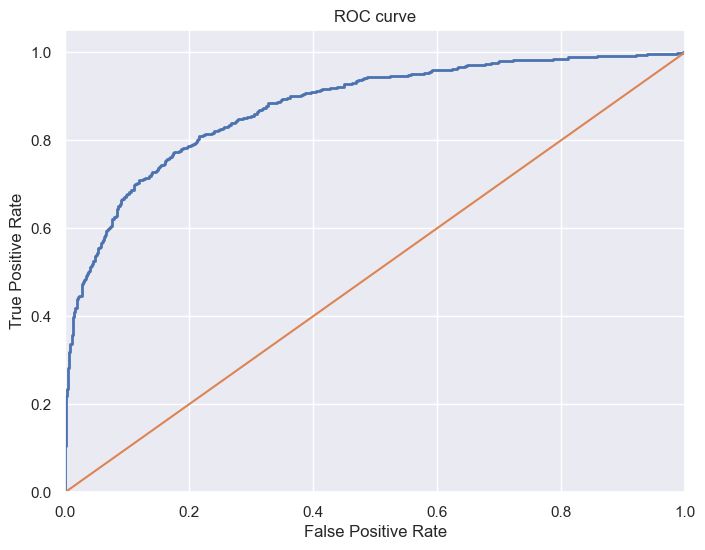

In [17]:
# Устанавливаем стиль графика и цветовую палитру
sns.set(font_scale=1)
sns.set_color_codes("muted")

# Создаем новую фигуру с заданным размером
plt.figure(figsize=(8, 6))

# Вычисляем значения FPR (False Positive Rate) и TPR (True Positive Rate) для построения кривой ROC
fpr, tpr, thresholds_ = roc_curve(y_test, preds, pos_label=1)

# Задаем ширину линии для графика ROC
lw = 2

# Рисуем кривую ROC
plt.plot(fpr, tpr, lw=lw, label='ROC curve')

# Рисуем диагональную линию (рандомная модель)
plt.plot([0, 1], [0, 1])

# Устанавливаем пределы для осей X и Y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Задаем подписи для осей и заголовок графика
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# Сохраняем график в файл "ROC.png"
plt.savefig("./image/ROC.png")

# Отображаем график
plt.show()


In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Функция выводит и рисует матрицу ошибок.
    Нормализация может быть применена, установив `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1809  182]
 [ 171  338]]


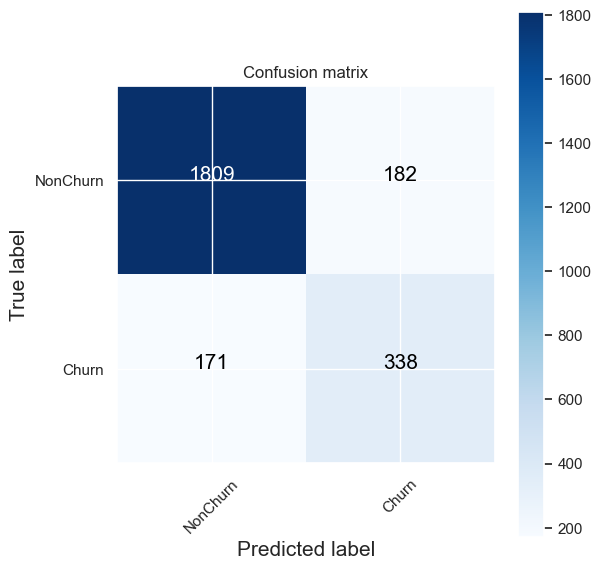

In [19]:
# Устанавливаем размер шрифта для графика
font = {'size' : 15}
plt.rc('font', **font)

# Вычисляем матрицу ошибок
cnf_matrix = confusion_matrix(y_test, preds > df_models_metrics.loc[df_models_metrics['roc-auc'].idxmax(),\
                                                                    'best_threshold'])

# Создаем график
plt.figure(figsize=(6, 6))
# Выводим матрицу ошибок с помощью функции plot_confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')

# Сохраняем график в файл
plt.savefig("./image/conf_matrix.png")

# Отображаем график
plt.show()


### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [20]:
# Заданные значения
retain_cost = 1  # Затраты на удержание одного пользователя
profit_per_tp = 2  # Средняя ожидаемая прибыль с каждого True Positive

TN = cnf_matrix[0][0]  # True Negative
FN = cnf_matrix[1][0]  # False Negative
TP = cnf_matrix[1][1]  # True Positive
FP = cnf_matrix[0][1]  # False Positive

# Вычисление экономических метрик
retain_sum = (FP + TP) * retain_cost  # Общие затраты
total_profit = TP * profit_per_tp  # Общая прибыль
net_profit = total_profit - retain_sum  # Чистая прибыль

# Вывод результатов
print(f'Общие затраты: ${retain_sum}')
print(f'Общая прибыль: ${total_profit}')
print(f'Чистая прибыль: ${net_profit}')


Общие затраты: $520
Общая прибыль: $676
Чистая прибыль: $156


### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [21]:
# Создаем пайплайн для классификации с использованием библиотеки CatBoost
classifier = Pipeline([
    ('features', feats),  # Трансформаторы для извлечения признаков
    ('classifier', CatBoostClassifier(silent=True, random_state=42))  # Классификатор CatBoost
])

# Обучение пайплайна на всем тренировочном датасете с использованием лучшей модели.
classifier.fit(X_train, y_train)

# Прогнозирование вероятностей и вывод информации о наилучшей производительности модели.
preds = classifier.predict_proba(X_test)[:, 1]

In [22]:
# Определяем сетку параметров для поиска по сетке
param_grid = {
    'classifier__n_estimators': [500, 600, 700, 800, 900],  # Количество деревьев
    'classifier__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],  # Скорость обучения
    'classifier__l2_leaf_reg': [20, 30, 40, 50, 60],  # L2 регуляризация
    'classifier__max_depth': [5, 6, 7, 8, 9]  # Максимальная глубина деревьев
}

# Создаем объект GridSearchCV для поиска по сетке
grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=6, scoring='accuracy', refit=False)


In [23]:
%%time 

# Запускаем процесс поиска по сетке с использованием данных обучения
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры, найденные в результате поиска по сетке
print("Best Parameters: ", grid_search.best_params_)

# Выводим лучшую точность (accuracy) модели, найденную в результате поиска по сетке
print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))


**Model results for the following parameters:**
- L2 Regularization: 60
- Learning Rate: 0.03
- Max Depth: 8
- Number of Estimators: 600

In [24]:
# Создаем новый пайплайн для классификации с использованием библиотеки CatBoost
new_classifier = Pipeline([
    ('features', feats),  # Трансформаторы для извлечения признаков
    ('classifier', CatBoostClassifier(l2_leaf_reg=60,
                                      learning_rate=0.03,
                                      max_depth=8,
                                      n_estimators=600,
                                      silent=True, 
                                      random_state=42))  # Классификатор CatBoost с лучшими параметрами
])

# Обучение пайплайна на всем тренировочном датасете с использованием лучшей модели.
new_classifier.fit(X_train, y_train)

# Прогнозирование вероятностей и вывод информации о наилучшей производительности модели.
new_preds = new_classifier.predict_proba(X_test)[:, 1]

In [25]:
# Вычисление точности (precision), полноты (recall) и пороговых значений для разных порогов
precision, recall, thresholds = precision_recall_curve(y_test.values, new_preds)

# Вычисление F-меры для каждой комбинации точности и полноты
fscore = 2 * (precision * recall) / (precision + recall)

# Находим индекс порога, при котором F-мера достигает максимального значения
ix = np.argmax(fscore)

# Вывод наилучшего порога и соответствующих метрик (F-меры, точности и полноты)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, \
Recall={recall[ix]:.3f}')

Best Threshold=0.34338644827339443, F-Score=0.660, Precision=0.639, Recall=0.682


### 5. (опционально) Еще раз провести оценку экономической эффективности

In [26]:
cnf_matrix = confusion_matrix(y_test, new_preds>thresholds[ix])

# Заданные значения
retain_cost = 1  # Затраты на удержание одного пользователя
profit_per_tp = 2  # Средняя ожидаемая прибыль с каждого True Positive

TN = cnf_matrix[0][0]  # True Negative
FN = cnf_matrix[1][0]  # False Negative
TP = cnf_matrix[1][1]  # True Positive
FP = cnf_matrix[0][1]  # False Positive

# Вычисление экономических метрик
retain_sum = (FP + TP) * retain_cost  # Общие затраты
total_profit = TP * profit_per_tp  # Общая прибыль
net_profit = total_profit - retain_sum  # Чистая прибыль

# Вывод результатов
print(f'Общие затраты: ${retain_sum}')
print(f'Общая прибыль: ${total_profit}')
print(f'Чистая прибыль: ${net_profit}')

Общие затраты: $542
Общая прибыль: $692
Чистая прибыль: $150


Confusion matrix, without normalization
[[1795  196]
 [ 163  346]]


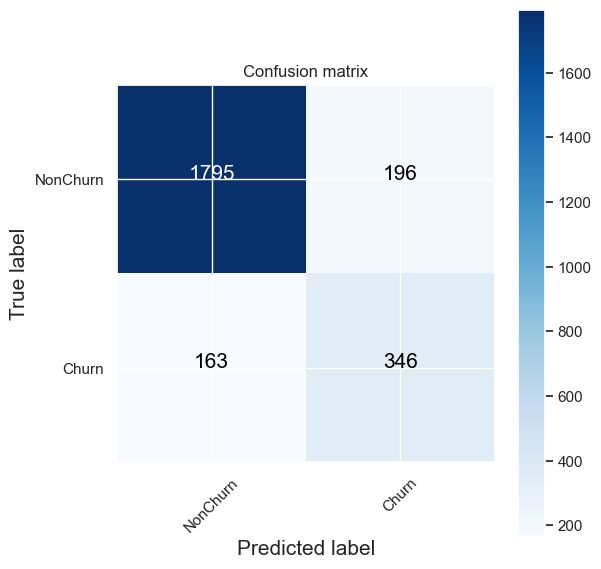

In [27]:
# Устанавливаем размер шрифта для графика
font = {'size' : 15}
plt.rc('font', **font)

# Вычисляем матрицу ошибок
cnf_matrix = confusion_matrix(y_test, new_preds>thresholds[ix])

# Создаем график
plt.figure(figsize=(6, 6))
# Выводим матрицу ошибок с помощью функции plot_confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')

# Сохраняем график в файл
plt.savefig("./image/conf_matrix_1.png")

# Отображаем график
plt.show()